In [55]:
!pip install numpy seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [11]:
import pandas as pd
import seaborn as sns

sns.set_theme()

yash_ip = "10.104.168.213" # I (Yash) logged in

In [47]:
logins = pd.read_csv(
    "data/logins.txt", sep=";", names=["Time", "IP", "Session"], parse_dates=["Time"]
)
logins = logins[logins["IP"] != yash_ip]
logins["Date"] = logins["Time"].map(lambda dt: dt.strftime("%m/%d"))
logins

,Time,IP,Session,Date
2,2024-04-16 20:40:05.426,220.180.188.224,08be04e0-fc53-11ee-8842-0d1fffd6c596,04/16
3,2024-04-17 00:07:33.754,158.69.39.171,04862160-fc70-11ee-ac0f-85d119f61f4f,04/17
4,2024-04-17 03:32:47.644,158.69.39.171,b02c0540-fc8c-11ee-8874-0936e530a934,04/17
5,2024-04-17 07:00:41.551,158.69.39.171,bb33c9b0-fca9-11ee-a857-e579227e6dc5,04/17
6,2024-04-17 10:10:44.819,179.43.180.108,48132d70-fcc4-11ee-95ce-3b26e94b4217,04/17
7,2024-04-17 10:11:04.338,183.81.169.238,53b71100-fcc4-11ee-95ce-3b26e94b4217,04/17
8,2024-04-17 11:45:52.505,183.81.169.238,92209f80-fcd1-11ee-95ce-3b26e94b4217,04/17
9,2024-04-17 11:59:21.742,124.112.116.217,74783cc0-fcd3-11ee-95ce-3b26e94b4217,04/17
10,2024-04-17 13:36:39.838,158.69.39.171,0c3e6180-fce1-11ee-800b-037bea88577d,04/17
11,2024-04-17 17:04:27.566,158.69.39.171,139727b0-fcfe-11ee-870e-4f8756332a89,04/17


In [36]:
login_attempts = pd.read_csv(
    "data/login_attempts.txt",
    sep=";",
    names=["Time", "IP", "method", "Name", "Password"],
    dtype={ "Name": "str", "Password": "str" },
    parse_dates=["Time"],
    # MITM doesn't wrap passwords with semicolons in them in quotes
    on_bad_lines=lambda lines: (
        lines[:-2] + [";".join(lines[-2:])] if len(lines) == 6 else lines
    ),
    engine="python",
)
logins = logins[logins["IP"] != yash_ip]
login_attempts.drop("method", axis=1, inplace=True)
login_attempts["Date"] = login_attempts["Time"].map(lambda dt: dt.strftime("%m/%d"))
login_attempts

,Time,IP,Name,Password,Date
0,2024-04-16 23:43:27.275,212.70.149.150,root,nimda,04/16
1,2024-04-16 23:43:38.676,158.69.39.171,postgres,Pass12345,04/16
2,2024-04-16 23:47:02.794,158.69.39.171,demo,!Q2w#E4r,04/16
3,2024-04-16 23:50:27.080,158.69.39.171,cloudtest,123456,04/16
4,2024-04-16 23:53:51.535,158.69.39.171,zookeeper,zookeeper,04/16
...,...,...,...,...,...
12746,2024-04-23 15:20:22.828,60.167.19.189,test,admin123,04/23
12747,2024-04-23 15:26:07.011,27.128.203.51,test,1978,04/23
12748,2024-04-23 15:33:46.217,212.70.149.150,root,mauricio,04/23
12749,2024-04-23 15:34:43.154,61.143.59.18,support,1337,04/23


In [37]:
login_attempts["IP"].value_counts().nlargest(15)

IP
158.69.39.171      1421
195.178.203.190    1215
113.250.177.51      719
58.251.255.204      715
183.81.169.238      556
170.64.214.38       476
112.91.138.229      411
157.230.40.249      395
179.43.180.108      355
209.38.154.41       339
87.98.138.142       294
64.23.249.216       286
170.64.202.235      283
170.64.234.198      283
170.64.229.252      283
Name: count, dtype: int64

In [38]:
login_attempts["Name"].value_counts().nlargest(15)

Name
root        5718
admin        674
user         436
test         329
ubuntu       306
oracle       195
ftpuser      145
postgres     131
deploy       109
test2        108
debian       107
test1        103
usuario      101
ubnt          81
demo          80
Name: count, dtype: int64

In [39]:
login_attempts["Password"].value_counts().nlargest(15)

Password
123456      967
123         266
admin       253
root        247
1234        187
12345       158
test        144
1           135
ubuntu      128
password    120
guest       107
qwerty      106
0            98
12345678     96
toor         96
Name: count, dtype: int64

In [41]:
(login_attempts["Name"].map(lambda n: n + " / ") + login_attempts["Password"]).value_counts().nlargest(15)

root / root        134
root / admin       102
root / 123456      100
root / 123          97
root / 0            92
root / 1            87
root / eve          78
admin / admin1      73
root / 123123       64
root / 12345        58
root / 1234         55
root / password     54
root / test         48
root / 111111       48
admin / admin       46
Name: count, dtype: int64

<Axes: xlabel='Date'>

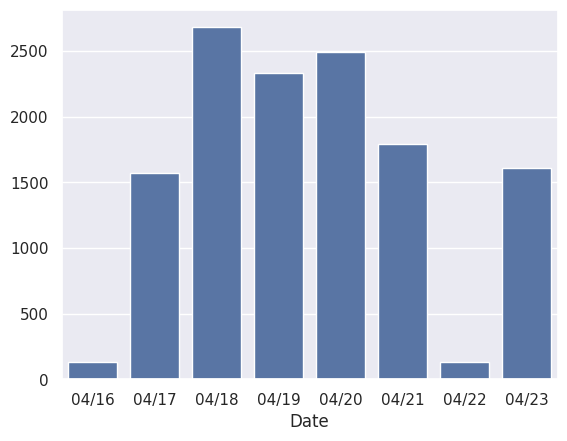

In [50]:
# Number of login attempts (not uniqued by IP)
by_day = login_attempts.groupby("Date").apply(lambda df: df["IP"].count(), include_groups=False)
sns.barplot(data=by_day)

<Axes: xlabel='Date'>

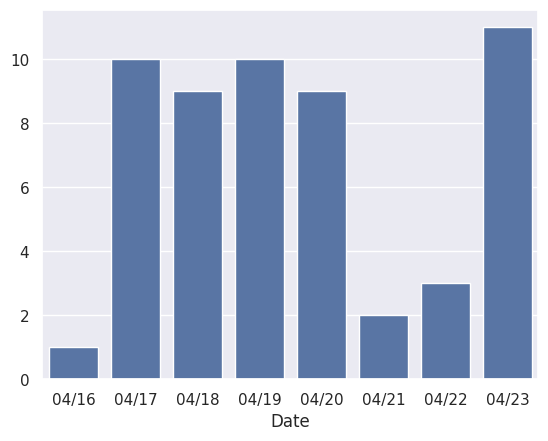

In [49]:
# Number of logins (not uniqued by IP)
by_day = logins.groupby("Date").apply(lambda df: df["IP"].count(), include_groups=False)
sns.barplot(data=by_day)

/tmp/ipykernel_43967/1470737387.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30)


[Text(0, 0, '2024-04-16'),
 Text(1, 0, '2024-04-17'),
 Text(2, 0, '2024-04-18'),
 Text(3, 0, '2024-04-19'),
 Text(4, 0, '2024-04-20'),
 Text(5, 0, '2024-04-21'),
 Text(6, 0, '2024-04-22'),
 Text(7, 0, '2024-04-23')]

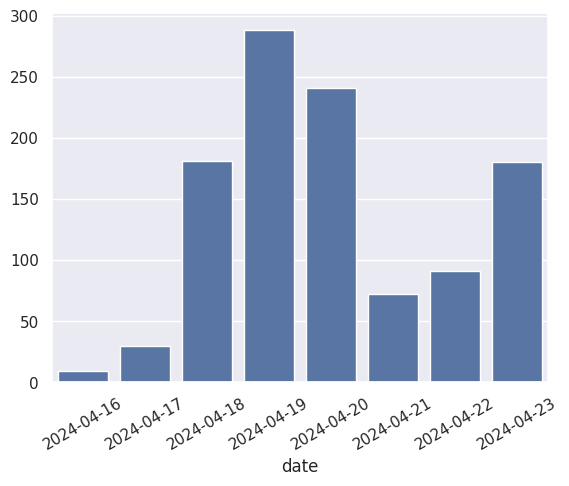

In [27]:
# Number of unique attackers each day
uniq_by_day = login_attempts.groupby("date").apply(lambda df: df["ip"].drop_duplicates().count(), include_groups=False)
g = sns.barplot(data=uniq_by_day)
g.set_xticklabels(g.get_xticklabels(), rotation=30)